In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('cloud_monitor.csv', parse_dates=['timestamp'], index_col='timestamp')

In [3]:
print(df.head())
print(df.info())

                                        Source.Name  value
timestamp                                                 
2014-02-14 14:30:00  ec2_cpu_utilization_24ae8d.csv  0.132
2014-02-14 14:35:00  ec2_cpu_utilization_24ae8d.csv  0.134
2014-02-14 14:40:00  ec2_cpu_utilization_24ae8d.csv  0.134
2014-02-14 14:45:00  ec2_cpu_utilization_24ae8d.csv  0.134
2014-02-14 14:50:00  ec2_cpu_utilization_24ae8d.csv  0.134
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67740 entries, 2014-02-14 14:30:00 to 2014-04-23 23:57:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Source.Name  67740 non-null  object 
 1   value        67740 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.6+ MB
None


In [4]:
df.interpolate(method='time', inplace=True)

In [9]:
print(df.dtypes)

Source.Name     object
value          float64
dtype: object


In [10]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
print("Numeric columns:", numeric_columns)

Numeric columns: Index(['value'], dtype='object')


In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
numeric_df = df[numeric_columns]

In [13]:
scaler = MinMaxScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df), index=numeric_df.index, columns=numeric_df.columns)

In [14]:
print(scaled_numeric_df.head())

                            value
timestamp                        
2014-02-14 14:30:00  1.527841e-10
2014-02-14 14:35:00  1.550991e-10
2014-02-14 14:40:00  1.550991e-10
2014-02-14 14:45:00  1.550991e-10
2014-02-14 14:50:00  1.550991e-10


In [15]:
non_numeric_df = df.drop(columns=numeric_columns) 
final_df = pd.concat([scaled_numeric_df, non_numeric_df], axis=1)

In [16]:
print(final_df.head())

                            value                     Source.Name
timestamp                                                        
2014-02-14 14:30:00  1.527841e-10  ec2_cpu_utilization_24ae8d.csv
2014-02-14 14:35:00  1.550991e-10  ec2_cpu_utilization_24ae8d.csv
2014-02-14 14:40:00  1.550991e-10  ec2_cpu_utilization_24ae8d.csv
2014-02-14 14:45:00  1.550991e-10  ec2_cpu_utilization_24ae8d.csv
2014-02-14 14:50:00  1.550991e-10  ec2_cpu_utilization_24ae8d.csv


In [17]:
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [22]:
print(scaled_numeric_df.columns)

Index(['value'], dtype='object')


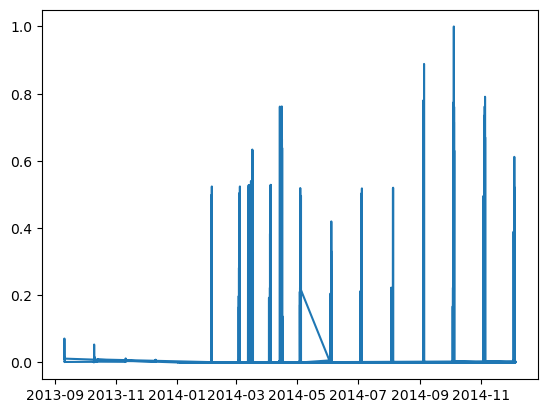

In [43]:
plt.plot(scaled_numeric_df.index, scaled_numeric_df['value'], label='CPU Utilization')

Text(0.5, 1.0, 'CPU Utilization Over Time (Scaled)')

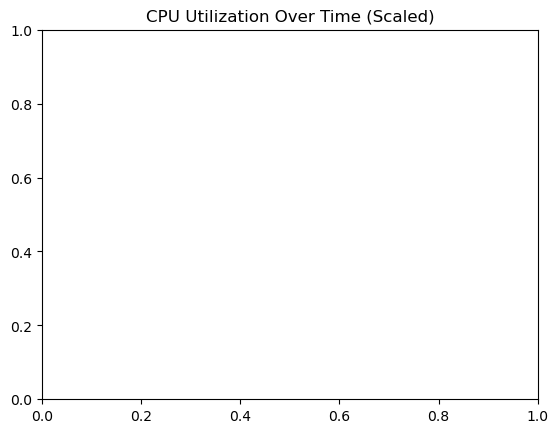

In [45]:
plt.title('CPU Utilization Over Time (Scaled)')

Text(0, 0.5, 'Scaled Value')

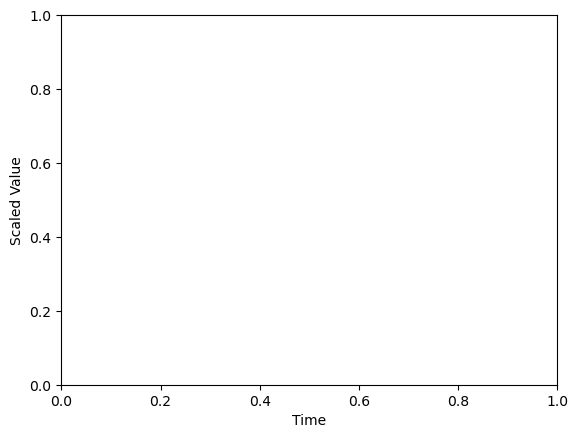

In [46]:
plt.xlabel('Time')
plt.ylabel('Scaled Value')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


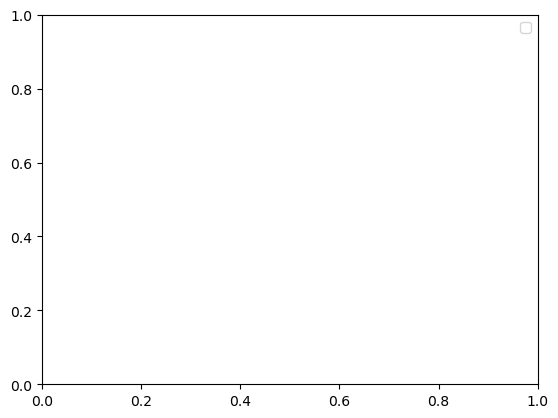

In [31]:
plt.legend()

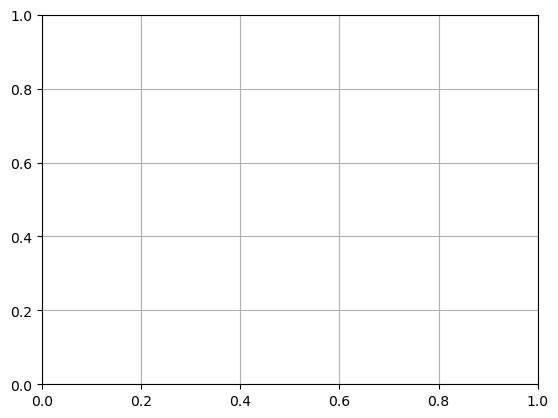

In [32]:
plt.grid(True)
plt.show()

In [38]:
from sklearn.ensemble import IsolationForest

In [40]:
model = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = model.fit_predict(scaled_numeric_df)

C:\Users\Chand\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [41]:
df['anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

In [42]:
anomalies = df[df['anomaly'] == 1]

In [47]:
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.scatter(anomalies.index, scaled_numeric_df.loc[anomalies.index]['value'], color='red', label='Anomaly', marker='0')

In [65]:
##Function to categorize anomalies based on rate of change

In [84]:
def categorize_anomaly(row, series):
    if row['anomaly'] == 1:
        diff = series.diff().abs()
        if diff[row.name] > 0.2:  # Define a threshold for significant change
            return 'Spike' if series.iloc[row.name] > series.mean() else 'Drop'
       
    return 'Normal'
df['cpu_anomaly_type'] = df.reset_index(drop=True).apply(lambda row: categorize_anomaly(row, scaled_numeric_df['value']), axis=1)

In [ ]:
spikes = df[df['cpu_anomaly_type'] == 'Spike']
drops = df[df['cpu_anomaly_type'] == 'Drop']
drifts = df[df['cpu_anomaly_type'] == 'Drift']

In [69]:
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

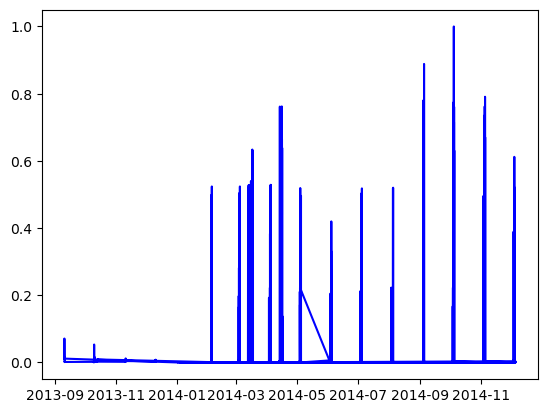

In [85]:
plt.plot(df.index, scaled_numeric_df['value'], label='CPU Utilization', color='blue')

# print(spike)

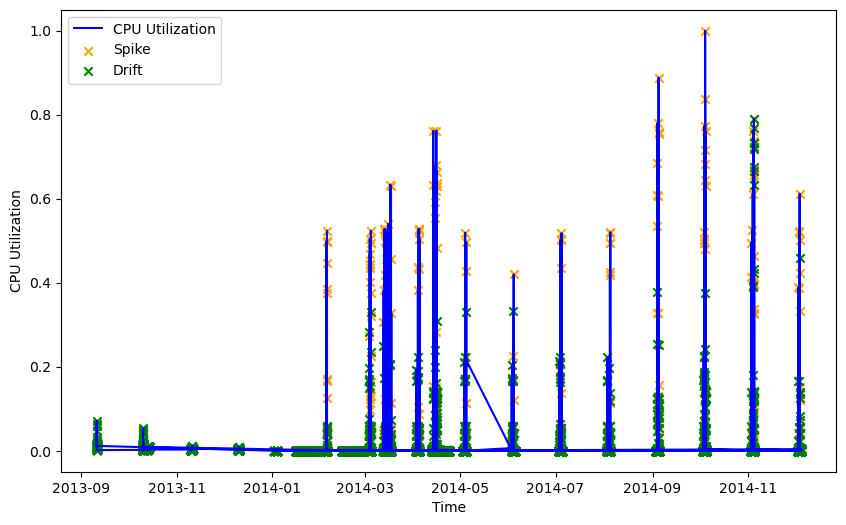

In [93]:
spike_threshold = 0.2  # Example: 20% change
mean_value = scaled_numeric_df['value'].mean()

# Detect spikes: where the difference is greater than the threshold
spike = scaled_numeric_df[scaled_numeric_df['value'].diff().abs() > spike_threshold]

# Detect drops: where the value is lower than the mean significantly
drops = scaled_numeric_df[scaled_numeric_df['value'] < (mean_value - spike_threshold)]

# Detect drifts: where the value changes gradually but significantly
drifts = scaled_numeric_df[(scaled_numeric_df['value'].diff().abs() > 0) & (scaled_numeric_df['value'].diff().abs() <= spike_threshold)]

# Now you can plot them
plt.figure(figsize=(10, 6))

# Plot CPU utilization
plt.plot(df.index, scaled_numeric_df['value'], label='CPU Utilization', color='blue')

# Plot spikes, drops, and drifts
if not spike.empty:
    plt.scatter(spike.index, spike['value'], color='orange', label='Spike', marker='x')
if not drops.empty:
    plt.scatter(drops.index, drops['value'], color='red', label='Drop', marker='x')
if not drifts.empty:
    plt.scatter(drifts.index, drifts['value'], color='green', label='Drift', marker='x')

# Labels and legend
plt.xlabel('Time')
plt.ylabel('CPU Utilization')
plt.legend()
plt.show()

## Anamoly severity scoring  

In [94]:
def anomaly_score(row, series):
    if row['anomaly'] == 1:
        deviation = abs(series[row.name] - series.mean())
        return deviation * 100  # Score scaled by a factor of 100 for visibility
    return 0

In [97]:
df['cpu_anomaly_score'] = df.apply(lambda row: anomaly_score(row, scaled_numeric_df['value']), axis=1)

In [99]:
print(df['cpu_anomaly_score'].dtype)

# Inspect the first few rows to see what kind of values are in the column
print(df['cpu_anomaly_score'].head())

# Check for non-numeric values
non_numeric = df[~df['cpu_anomaly_score'].apply(lambda x: isinstance(x, (int, float)))]
print(non_numeric)

object
timestamp
2014-02-14 14:30:00    0
2014-02-14 14:35:00    0
2014-02-14 14:40:00    0
2014-02-14 14:45:00    0
2014-02-14 14:50:00    0
Name: cpu_anomaly_score, dtype: object
                                         Source.Name        value  anomaly  \
timestamp                                                                    
2014-02-04 15:00:00  ec2_disk_write_bytes_c0d644.csv   19949200.0        1   
2014-02-04 15:05:00  ec2_disk_write_bytes_c0d644.csv   48951300.0        1   
2014-02-04 15:10:00  ec2_disk_write_bytes_c0d644.csv  431199000.0        1   
2014-02-04 15:15:00  ec2_disk_write_bytes_c0d644.csv   36434700.0        1   
2014-02-04 17:05:00  ec2_disk_write_bytes_c0d644.csv   34572700.0        1   
...                                              ...          ...      ...   
2014-04-16 06:30:00  ec2_disk_write_bytes_c0d644.csv   76687800.0        1   
2014-04-16 06:35:00  ec2_disk_write_bytes_c0d644.csv   56834500.0        1   
2014-04-15 16:54:00        ec2_network_

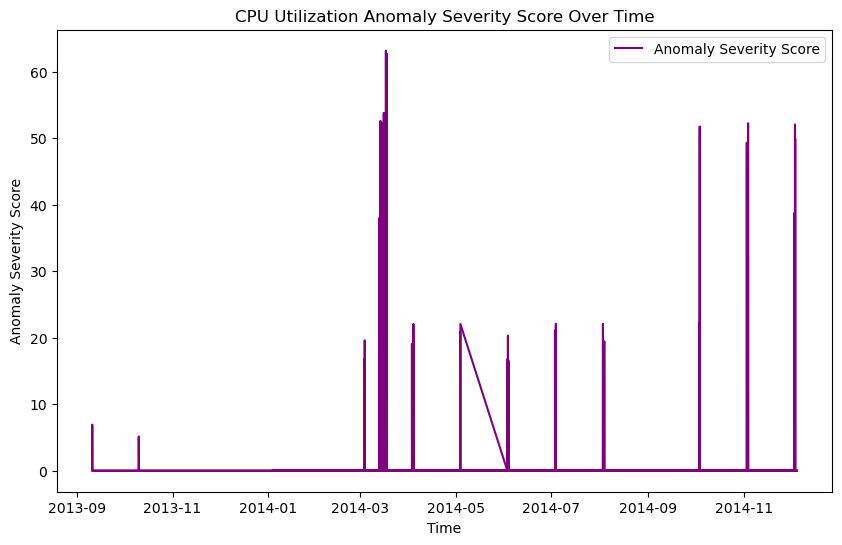

In [100]:
df['cpu_anomaly_score'] = pd.to_numeric(df['cpu_anomaly_score'], errors='coerce')

# Optionally, fill NaN values if you want to handle them (e.g., with the mean value or 0)
df['cpu_anomaly_score'].fillna(df['cpu_anomaly_score'].mean(), inplace=True)

# Now try plotting again
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['cpu_anomaly_score'], label='Anomaly Severity Score', color='purple')
plt.title('CPU Utilization Anomaly Severity Score Over Time')
plt.xlabel('Time')
plt.ylabel('Anomaly Severity Score')
plt.legend()
plt.show()

# # Visualisation Dashboard 

In [101]:
plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

NameError: name 'scaled_df' is not defined

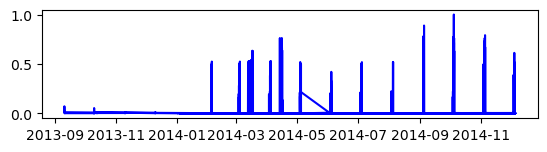

In [108]:
plt.subplot(3, 1, 1)
plt.plot(df.index, scaled_numeric_df['value'], label='CPU Utilization', color='blue')
plt.scatter(anomalies.index, scaled_df.loc[anomalies.index]['cpu_utilization'], color='red', label='Anomaly', marker='x')
plt.title('CPU Utilization Over Time')
plt.xlabel('Time')
plt.ylabel('Scaled Value')
plt.grid(True)

NameError: name 'scaled_df' is not defined

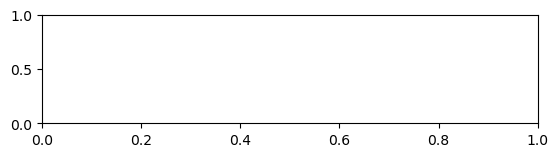

In [106]:
plt.subplot(3, 1, 2)
plt.plot(df.index, scaled_df['cpu_utilization'], label='CPU Utilization', color='blue')
plt.scatter(spikes.index, scaled_df.loc[spikes.index]['cpu_utilization'], color='orange', label='Spike', marker='x')
plt.scatter(drops.index, scaled_df.loc[drops.index]['cpu_utilization'], color='red', label='Drop', marker='x')
plt.scatter(drifts.index, scaled_df.loc[drifts.index]['cpu_utilization'], color='green', label='Drift', marker='x')
plt.title('Anomaly Categorization')
plt.xlabel('Time')
plt.ylabel('Scaled Value')
plt.grid(True)

In [111]:
print(df.columns)

Index(['Source.Name', 'value', 'anomaly', 'cpu_anomaly_type',
       'cpu_anomaly_score'],
      dtype='object')


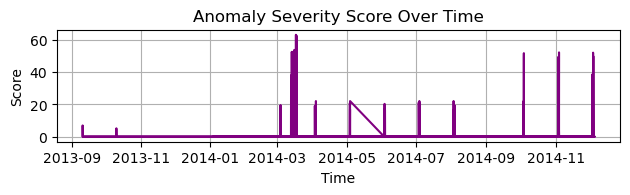

In [114]:
plt.subplot(3, 1, 3)
plt.plot(df.index, df['cpu_anomaly_score'], label='Anomaly Score', color='purple')
plt.title('Anomaly Severity Score Over Time')
plt.xlabel('Time')
plt.ylabel('Score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming df contains 'cpu_utilization'
# Step 1: Scale the 'cpu_utilization' column
scaler = MinMaxScaler()

# Scale the CPU utilization data
df['cpu_utilization_scaled'] = scaler.fit_transform(df[['cpu_utilization]])

# Create scaled_df with the scaled 'cpu_utilization' column
scaled_df = df[['cpu_utilization_scaled']].copy()
scaled_df.rename(columns={'cpu_utilization_scaled': 'cpu_utilization'}, inplace=True)

# Step 2: Define anomaly categories (dummy example for illustration)
# You need to actually calculate 'spikes', 'drops', and 'drifts' according to your logic
threshold = 0.8
spikes = scaled_df[scaled_df['cpu_utilization'] > threshold]
drops = scaled_df[scaled_df['cpu_utilization'] < 0.2]  # Example for drops
drifts = scaled_df[(scaled_df['cpu_utilization'] > 0.2) & (scaled_df['cpu_utilization'] < threshold)]  # Example for drifts

# Step 3: Plot CPU Utilization and anomalies
plt.figure(figsize=(10, 8))

# First subplot: Anomaly categorization
plt.subplot(3, 1, 2)
plt.plot(df.index, scaled_df[''], label='CPU Utilization', color='blue')

# Plot anomaly types if they exist
if not spikes.empty:
    plt.scatter(spikes.index, scaled_df.loc[spikes.index]['cpu_utilization'], color='orange', label='Spike', marker='x')
if not drops.empty:
    plt.scatter(drops.index, scaled_df.loc[drops.index]['cpu_utilization'], color='red', label='Drop', marker='x')
if not drifts.empty:
    plt.scatter(drifts.index, scaled_df.loc[drifts.index]['cpu_utilization'], color='green', label='Drift', marker='x')

plt.title('Anomaly Categorization')
plt.xlabel('Time')
plt.ylabel('Scaled Value')
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Explainability with SHAP 

In [117]:
pip install shap

     -------------------------------------- 456.1/456.1 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [119]:
import shap
from sklearn.ensemble import RandomForestRegressor

In [120]:
X = scaled_df.drop(columns=['cpu_utilization'])
y = scaled_df['cpu_utilization']

In [122]:
print(type(X))
print(type(y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [123]:
print(X.shape)
print(y.shape)
print(X.head())  # if X is a DataFrame
print(y.head()) 

(67740, 0)
(67740,)
Empty DataFrame
Columns: []
Index: [2014-02-14 14:30:00, 2014-02-14 14:35:00, 2014-02-14 14:40:00, 2014-02-14 14:45:00, 2014-02-14 14:50:00]
timestamp
2014-02-14 14:30:00    0.0
2014-02-14 14:35:00    0.0
2014-02-14 14:40:00    0.0
2014-02-14 14:45:00    0.0
2014-02-14 14:50:00    0.0
Name: cpu_utilization, dtype: float64


In [124]:
print(X.isnull().sum())  # if X is a DataFrame
print(y.isnull().sum())

Series([], dtype: float64)
0


In [126]:
assert len(X) == len(y)

In [128]:
X = X.astype(float)
y = y.astype(float)

In [129]:
X = X.to_numpy()
y = y.to_numpy()

In [130]:
from scipy.sparse import issparse

if issparse(X):
    X = X.toarray()

In [135]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X,y)

ValueError: Found array with 0 feature(s) (shape=(67740, 0)) while a minimum of 1 is required by RandomForestRegressor.

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Visualize SHAP values for the first data point
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])